# Exercise 2c

We will follow this online tutorial to construct our CNN and train our data: https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

First we import the libraries we need:

In [112]:
# importing the libraries
import numpy as np
import time

# for evaluating the model
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# PyTorch libraries and modules
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

# for importing the images
from PIL import Image
from os import listdir
from functools import reduce

Next, we load the images (you might have to adjust the paths here):

In [113]:
# benno
# train_folder = "C:/Users/bennx/OneDrive/Desktop/mnist-png-format/train/"
# test_folder = "C:/Users/bennx/OneDrive/Desktop/mnist-png-format/test/"

# david
train_folder = "../mnist-png-format/train/"
test_folder = "../mnist-png-format/test/"

def load_images(folder_path):
    data = {float(s): [np.asarray(Image.open(f"{folder_path}/{s}/{p}")).reshape(-1, )
        for p in listdir(f"{folder_path}{s}")
    ] for s in listdir(folder_path)}

    (ys, xs) = reduce(
        lambda a, b: (a[0] + [b[0]]*len(b[1]), a[1] + b[1]),
        data.items(),
        ([], [])
    )
    return np.array(ys), np.array(xs)

y_test1, x_test1 = load_images(test_folder)
y_train1, x_train1 = load_images(train_folder)

# normalizing the pixel values (this step helps in optimizing the performance of our model)
x_test1 = np.float32((np.true_divide(x_test1, 255.0)))
x_train1 = np.float32((np.true_divide(x_train1, 255.0)))

print(f"Shape of x_train: {x_train1.shape}; shape of y_train: {y_train1.shape}.")
print(f"Shape of x_test: {x_test1.shape}; shape of y_test: {y_test1.shape}.")

Shape of x_train: (60000, 784); shape of y_train: (60000,).
Shape of x_test: (10000, 784); shape of y_test: (10000,).


Since we work with torch, we have to convert our images into a tensor format.

Be aware of dtypes: float64 will be interpreted as double in torch for tensors. int32 will be interpreted as int, but we need torch.LongTensor when we use train()!

In [114]:
# converting training images into torch format
x_train = x_train1.reshape(60000, 1, 28, 28)
x_train  = torch.from_numpy(x_train)

# converting test images into torch format
x_test = x_test1.reshape(10000, 1, 28, 28)
x_test  = torch.from_numpy(x_test)

# converting the train target into torch format
y_train = y_train1.astype(int);
y_train = torch.from_numpy(y_train)
y_train = y_train.type(torch.LongTensor)

# converting the test target into torch format
y_test = y_test1.astype(int);
y_test = torch.from_numpy(y_test)
y_test = y_test.type(torch.LongTensor)

# shape of training and test data
print(f"Shape of x_train: {x_train.shape}; shape of y_train: {y_train.shape}.")
print(f"Shape of x_test: {x_test.shape}; shape of y_test: {y_test.shape}.")

Shape of x_train: torch.Size([60000, 1, 28, 28]); shape of y_train: torch.Size([60000]).
Shape of x_test: torch.Size([10000, 1, 28, 28]); shape of y_test: torch.Size([10000]).


So, let us fill the missing gaps in the exercise CNN template. Since the images above are stored in 28x28 matrices, it is clear that the first gap "self.expected_input_size" must have the shape (28, 28). <br>

The second gap is a little bit more complicated. Lets skip it and first do the last gap: "nn.Linear(1536, ___)". This is the last layer (the layer for the final classification). Our data are digits from 0 to 9, thus the value in the missing gap must be 10, since the result should be one of the 10 classes.<br>

Now the second gap. in_channels is also quite simple, our images are in greyscale, so there is only one incoming channel (RGB would be for example 3). We know that the last layer has dimension 1536x1 after flattening. So we can calculate the out_channels and kernel_size, sinze we know the input size and stride. First we do a prime factorization of $1536 = 2^9 \cdot 3$. Since we have a quadratic matrix, we will have its output size after the first layer squared and then multiplied with the output channels. We can conclude from the prime factorization that the number of out_channels is either 6, 24, 96, ..., therefore we consider the formula to calculate the output size (before out_channels): $o = \frac{i-k+2p}{s}+1$, where $i$ is the input size, $k$ the kernel size, $p$ the padding and $s$ the stride. In our case $i=28, p=0, s=3$, so to get an reasonable value for $o$ (the kernel should be bigger than 1 and not too big); so we see that if $1 \leq k \leq 4$ we will get $o=9$, which cannot be the case, since 1536 has not enough 3's as prime factors. So we conclude that $5 \leq k \leq 7$ to get $o=8$; depending on the implementation, but usually the fraction above will be rounded down to the nearest integer, but just to be safe we choose $k=7$. Now we can calculate the missing factors and conclude out_channels = 24.

In [115]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class PR_CNN(nn.Module):
    def __init__(self, **kwargs):
        super(PR_CNN, self).__init__()

        self.expected_input_size = (28, 28)

        # First layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=24, kernel_size=7, stride=3),
            nn.LeakyReLU()
        )

        # Classification layer
        self.fc = nn.Sequential(
            Flatten(),
            nn.Linear(1536, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.fc(x)
        return x

Now it is time to define our model. Since we are not really familiar with the best optimizers or loss functions, we just copied the ones from the tutorial.

In [116]:
# defining the model
model = PR_CNN()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

PR_CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 24, kernel_size=(7, 7), stride=(3, 3))
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fc): Sequential(
    (0): Flatten()
    (1): Linear(in_features=1536, out_features=10, bias=True)
  )
)


Finally we have the model of our CNN, but we also need to define a function to train the model:

In [117]:
def get_train(model, opt, silent=True):
    def train(epoch):
        model.train()
        # getting the training set
        x_tr, y_tr = Variable(x_train), Variable(y_train)
        # converting the data into GPU format
        if torch.cuda.is_available():
            x_tr = x_tr.cuda()
            y_tr = y_tr.cuda()

        # clearing the Gradients of the model parameters
        opt.zero_grad()
        
        # prediction for training  set
        output_train = model(x_tr)

        # computing the training loss
        loss_train = criterion(output_train, y_tr)
        train_losses.append(loss_train)

        # computing the updated weights of all the model parameters
        loss_train.backward()
        opt.step()
        if epoch%2 == 0 and not silent:
            # printing the train loss
            print('Epoch : ',epoch+1, '\t', 'loss :', loss_train.detach())
    
    return train

And finally we can start train the model. As a test we start with 25 epochs.

In [118]:
t25 = time.perf_counter()
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# training the model
for epoch in range(n_epochs):
    get_train(model, optimizer, silent=False)(epoch)
t25 = time.perf_counter() - t25
print(f"Time spent to the train the model: {round(t25,2)} seconds.")

Epoch :  1 	 loss : tensor(2.3018)
Epoch :  3 	 loss : tensor(3.5915)
Epoch :  5 	 loss : tensor(0.9446)
Epoch :  7 	 loss : tensor(0.6455)
Epoch :  9 	 loss : tensor(0.5545)
Epoch :  11 	 loss : tensor(0.4491)
Epoch :  13 	 loss : tensor(0.3899)
Epoch :  15 	 loss : tensor(0.3166)
Epoch :  17 	 loss : tensor(0.2929)
Epoch :  19 	 loss : tensor(0.2686)
Epoch :  21 	 loss : tensor(0.2443)
Epoch :  23 	 loss : tensor(0.2146)
Epoch :  25 	 loss : tensor(0.2009)
Time spent to the train the model: 25.31 seconds.


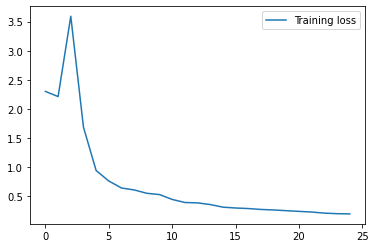

In [119]:
# plotting the training and validation loss
train_losses = [x.detach() for x in train_losses]
plt.plot(train_losses, label='Training loss')
plt.legend()
plt.show()

In [120]:
# prediction for training set
# with torch.no_grad():
#     output = model(x_train.cuda())

with torch.no_grad():
     output_tr = model(x_train) 
softmax_tr = torch.exp(output_tr).cpu()
prob_tr = list(softmax_tr.numpy())
predictions_tr = np.argmax(prob_tr, axis=1)

# accuracy on training set
accuracy_score(y_train, predictions_tr)

0.94515

In [121]:
# generating predictions for test set
# with torch.no_grad():
#     output = model(x_test.cuda())

with torch.no_grad():
    output_te = model(x_test)

softmax_te = torch.exp(output_te).cpu()
prob_te = list(softmax_te.numpy())
predictions_te = np.argmax(prob_te, axis=1)

# accuracy on training set
accuracy_score(y_test, predictions_te)

0.9462

Now we optimize our classifier (relative to the test data). First we try different learning rates:

In [122]:
def train_with_n_epochs(n_epochs, train):
    t = time.perf_counter()

    for e in range(n_epochs):
        train(e)

    return time.perf_counter() - t

def train_and_eval(n_epochs, lr):
    model = PR_CNN()
    opt = Adam(model.parameters(), lr=lr)

    t = train_with_n_epochs(n_epochs, get_train(model, opt))

    with torch.no_grad():
        output_te = model(x_test)

    predictions_te = np.argmax(
        torch.exp(output_te)
            .cpu()
            .numpy(),
        axis=1
    )

    return t, accuracy_score(y_test, predictions_te)

rates = [0.001, 0.005, 0.01, 0.05, 0.1]
accuracies = [train_and_eval(25, lr) for lr in rates]
for (t_acc, lr) in zip(accuracies, rates):
    t, acc, = t_acc
    print(f"accuracy {acc} for lr={lr} (time spent to train: {round(t, 2)} seconds)")

accuracy 0.8274 for lr=0.001 (time spent to train: 25.69 seconds)
accuracy 0.9237 for lr=0.005 (time spent to train: 25.93 seconds)
accuracy 0.9372 for lr=0.01 (time spent to train: 25.97 seconds)
accuracy 0.9382 for lr=0.05 (time spent to train: 25.17 seconds)
accuracy 0.9223 for lr=0.1 (time spent to train: 25.77 seconds)


We seem to get the best results for a learing rate around 0.05. Let's now try different numbers of epochs:

In [126]:
ns_epochs = [60, 50, 40, 30, 20, 10, 5]
accuracies = [train_and_eval(ne, 0.05) for ne in ns_epochs]

for (t_acc, n_epochs) in zip(accuracies, ns_epochs):
    t, acc, = t_acc
    print(f"accuracy {acc} for n_epochs={n_epochs} (time spent to train: {round(t, 2)} seconds)")

accuracy 0.9724 for n_epochs=60 (time spent to train: 63.15 seconds)
accuracy 0.9751 for n_epochs=50 (time spent to train: 51.98 seconds)
accuracy 0.971 for n_epochs=40 (time spent to train: 40.87 seconds)
accuracy 0.9453 for n_epochs=30 (time spent to train: 30.78 seconds)
accuracy 0.9303 for n_epochs=20 (time spent to train: 19.88 seconds)
accuracy 0.8925 for n_epochs=10 (time spent to train: 9.86 seconds)
accuracy 0.793 for n_epochs=5 (time spent to train: 4.92 seconds)


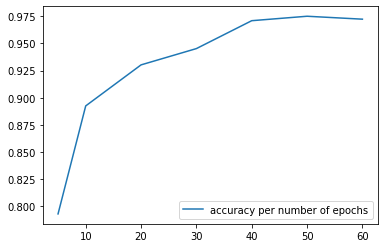

In [128]:
accuracy_data = [acc for (_, acc) in accuracies]
plt.plot(ns_epochs, accuracy_data, label='accuracy per number of epochs')
plt.legend()
plt.show()

We seem to reach a plateau at around 40 epochs, so 40 should be enough.